# Some global things

In [1]:
### Global
import numpy as np

from scipy.interpolate import interp1d
from scipy.integrate import simps
from chainconsumer import ChainConsumer

import matplotlib.pyplot as plt

### Local
from utilities_simplified import *

### For plotting
import matplotlib
matplotlib.rcParams['text.usetex'] = True
plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)
plt.rcParams.update({'axes.labelsize': 20, 'legend.fontsize': 20 })

In [2]:
### GW150914 parameters 
### Are these the masses in detector's frame???
m1   = 36       #solarmass
m2   = 29

dL   = 410      #Mpc
zem  = 0.09

yr_s = 365 *24 *3600 
t_yr = 4.
time = t_yr *yr_s # time before merger in sec
tc   = 0
psic = 0

H    = cosmo_params['h'] *100 *1e3 /Mpc

In [3]:
#Read in and interpolate LIGO and LISA PSDs.
path_to_data = '../../data/'

ligo_data    = np.genfromtxt(path_to_data 
                +'L1_O3_strain.txt')
ligo_data    = ligo_data[(ligo_data[:,0]>=10) & (ligo_data[:,0]<=6e3)]

                #+'lalsimulation_lib_LIGO-T1800545-v1-aLIGO_175Mpc.txt')
LISA_strain  = np.loadtxt(path_to_data+'LISA_strain.txt')

ligo_interp  = interp1d(ligo_data[:,0], ligo_data[:,1], bounds_error=False, fill_value=1e50)
lisa_interp  = interp1d(LISA_strain[:,0], LISA_strain[:,3])

fligo   = np.logspace(np.log10(ligo_data[0,0]), np.log10(ligo_data[-2,0]), 1000)
flisa   = np.logspace(np.log10(LISA_strain[0,0]), np.log10(LISA_strain[-1,0]), 1000)

In [4]:
### Get dL
dL_s   = dL *Mpc  *c    # Dl in sec

### Get mass quantities (are these in source or detector frame???)
m_eff  = m1 *m2 /(m1+m2)
Ms     = m_eff**(3. /5) * (m1 +m2)**(2./5)     # chirp mass in solarmass
eta    = ((m1 +m2) /Ms)**(-5./3)

Ms_s   = Ms *Msolar *GN /c**3.       # chirp mass in sec
Mtot_s = (m1+m2) *Msolar *GN /c**3.


### Get frequency ranges for inspiral and plots
# starting frequency at the time before merger
f_start = (5 *Ms_s /256 /time)**(3./8) /np.pi /Ms_s  

#### NB!!!!! inspiral_fc wants redshifted total mass why is this source?
fc      = inspiral_fc(Mtot_s)
farr    = np.logspace(np.log10(f_start), np.log10(fc),num=500)     # inspiral range only
Dl_arr  = np.array([dL_s]*len(farr))

In [5]:
print(f_start, fc)

0.017210801759346805 67.63181124855085


In [6]:
### Test that time to merger is t_yr
to_int  = 1 /( 96/5 * np.pi**(8/3) *(Ms_s)**(5/3) *farr**(11/3) )
simps(to_int, x=farr) /365.25 /24 /3600

3.9972955357790534

In [7]:
pars_GR     = np.array([np.log(Ms), np.log(eta), np.log(zem), tc, psic, 0, 0])
#label_GR    = [r'$\Delta \ln \left( \frac{ {\cal M}_o }{ M_{\odot} } \right)$', r'$ \Delta \ln \eta $', 
#                r'$\Delta \ln z $',r'$\Delta t_c$ [ms]',r'$ \Delta \Psi_c$']

label_GR    = [r'$\Delta {\cal M}_o /{\cal M}_o $', r'$  \Delta \eta / \eta $', 
                r'$\Delta d_L /d_L $',r'$\Delta t_c$ [s]',r'$ \Delta \Psi_c$']

In [8]:
# Get waveform segments in LISA and LIGO ranges only.
n_points  = 500
farr_ligo = np.logspace(np.log10(ligo_data[0,0]), np.log10(fc),num=n_points)
farr_lisa = np.logspace(np.log10(f_start),np.log10(LISA_strain[-1,0]),num=n_points)

ligo_psd  = ligo_interp(farr_ligo)**2
lisa_psd  = lisa_interp(farr_lisa)

h_GR_ligo = h_Delta_inspiral(farr_ligo, pars_GR, dist_corr=False)
h_GR_lisa = h_Delta_inspiral(farr_lisa, pars_GR, dist_corr=False)

print('SNR LIGO = %.2f, SNR LISA = %.2f' % ( scalar_product(h_GR_ligo, h_GR_ligo, ligo_psd, farr_ligo)**(.5), 
      scalar_product(h_GR_lisa, h_GR_lisa, lisa_psd, farr_lisa)**(.5) ) )

SNR LIGO = 43.94, SNR LISA = 4.67


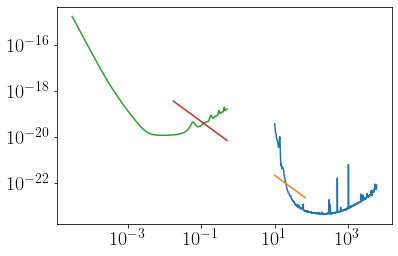

In [9]:
plt.loglog(fligo, ligo_interp(fligo))
plt.loglog(farr_ligo, np.abs(h_GR_ligo))

plt.loglog(flisa, np.sqrt(lisa_interp(flisa)) ) 
plt.loglog(farr_lisa, np.abs(h_GR_lisa));

# GR Constraints

In [10]:
### Start with LIGO!!! 
wf_ligo_nd = h_Delta_inspiral(farr_ligo, pars_GR, cT_type='GR')

dlnA_ligo_GR, dPsi_ligo_GR = Fisher_der(farr_ligo, pars_GR, cT_type='GR')

FlnA_ligo_GR = Fisher_build(farr_ligo, ligo_psd, wf_ligo_nd, dlnA_ligo_GR)
FPsi_ligo_GR = Fisher_build(farr_ligo, ligo_psd, wf_ligo_nd, dPsi_ligo_GR)

-Working on index 0
Ratio best = 2.79e-14 for dx = 3.34e-01
Ratio best = 5.68e-03 for dx = 1.67e-01
-Working on index 1
Ratio best = 2.42e-03 for dx = 1.40e-01
-Working on index 2
-Working on index 3
-Working on index 4
-Working on index 5
This took 1.67 seconds


In [11]:
fisher_ligo_GR       = FlnA_ligo_GR +FPsi_ligo_GR
cov_matrix_ligo_GR   = np.linalg.inv(fisher_ligo_GR)
pconstraints_ligo_GR = np.sqrt(np.diag(cov_matrix_ligo_GR))

print('\nLIGO conditioning (units of 1e15)')
print(np.linalg.cond(fisher_ligo_GR)/1e15)
print('\nLIGO GR constraints')
print(pconstraints_ligo_GR)


LIGO conditioning (units of 1e15)
4.996623485459383e-08

LIGO GR constraints
[0.03265012 0.37474987 0.03342688 0.0010695  0.40031237]


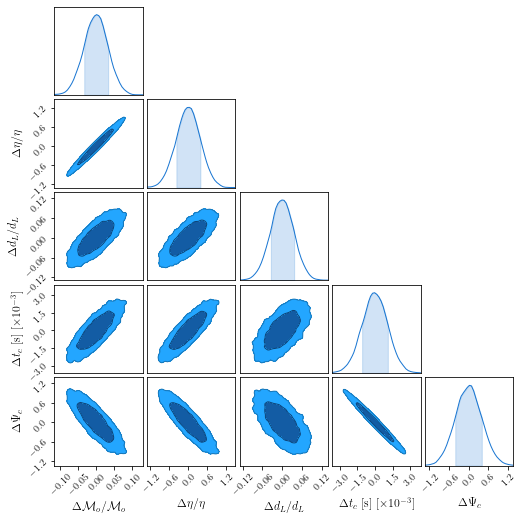

In [12]:
data_ligo_GR         = np.random.multivariate_normal(0 *pars_GR[:-2], cov_matrix_ligo_GR, size=10000)
data_dL_ligo_GR      = np.array(data_ligo_GR)
data_dL_ligo_GR[:,2] = get_dL_Mpc(zem *(1 +data_ligo_GR[:,2])) / get_dL_Mpc(zem) -1
#data_dL_ligo_GR[:,3] *= 1e3

cc = ChainConsumer()
cc.add_chain(data_dL_ligo_GR, bins=30, smooth=True, parameters=label_GR, name='ligo');
cc.plotter.plot();

In [13]:
### Then with LISA, NO DIST corr here!!! 
wf_lisa = h_Delta_inspiral(farr_lisa, pars_GR, cT_type='GR', dist_corr=False)

dlnA_lisa_GR, dPsi_lisa_GR = Fisher_der(farr_lisa, pars_GR, cT_type='GR', dist_corr=False)

FlnA_lisa_GR = Fisher_build(farr_lisa, lisa_psd, wf_lisa, dlnA_lisa_GR)
FPsi_lisa_GR = Fisher_build(farr_lisa, lisa_psd, wf_lisa, dPsi_lisa_GR)

-Working on index 0
Ratio best = 1.69e-14 for dx = 3.34e-01
Ratio best = 5.68e-03 for dx = 1.67e-01
-Working on index 1
Ratio best = 3.47e-03 for dx = 1.40e-01
-Working on index 2
-Working on index 3
-Working on index 4
-Working on index 5
This took 1.68 seconds


In [14]:
fisher_lisa_GR       = FlnA_lisa_GR +FPsi_lisa_GR
cov_matrix_lisa_GR   = np.linalg.inv(fisher_lisa_GR)
pconstraints_lisa_GR = np.sqrt(np.diag(cov_matrix_lisa_GR))

print('\nLISA conditioning (units of 1e15)')
print(np.linalg.cond(fisher_lisa_GR)/1e15)
print('\nLISA GR constraints')
print(pconstraints_lisa_GR)

evals_lisa_GR, evecs_lisa_GR = np.linalg.eigh(fisher_lisa_GR)
print('\nEigenvals:\n', evals_lisa_GR)

print('\nSmallest eigenval:\n', evecs_lisa_GR[0,:])
print('\nLargest eigenval:\n', evecs_lisa_GR[-1,:])


LISA conditioning (units of 1e15)
21.928337872312724

LISA GR constraints
[2.31471900e-06 1.61958390e-02 2.01761866e-01 3.50074932e+00
 1.18853305e+00]

Eigenvals:
 [7.65213833e-02 1.66728947e+00 2.45652862e+01 9.95577396e+03
 1.67798675e+15]

Smallest eigenval:
 [-2.66551877e-07  2.01668283e-06 -3.50029607e-11 -1.40738678e-04
  9.99999990e-01]

Largest eigenval:
 [ 2.55340775e-01  9.66768753e-01  1.59232149e-06  1.26201192e-02
 -1.05465488e-07]


In [15]:
### Reducing magnitude of some parameters and computing new fisher
new_dlnA_lisa_GR = np.array(dlnA_lisa_GR)
new_dPsi_lisa_GR = np.array(dPsi_lisa_GR)

rescaling_matrix      = np.eye( len(dlnA_lisa_GR) )
rescaling_matrix[0,0] = 1e-4 #3e-3
rescaling_matrix[1,1] = 1e-4 #1e-7
rescaling_matrix[2,2] = 1e0
rescaling_matrix[3,3] = 1 #1e-1
rescaling_matrix[4,4] = 1 #1e-1

#d_new_ligo = np.matmul(rescaling_matrix, ders_ligo_GR_dist)
new_dlnA_lisa_GR = np.matmul(rescaling_matrix, new_dlnA_lisa_GR)
new_dPsi_lisa_GR = np.matmul(rescaling_matrix, new_dPsi_lisa_GR)

new_FlnA_lisa_GR = Fisher_build(farr_lisa, lisa_psd, wf_lisa, new_dlnA_lisa_GR)
new_FPsi_lisa_GR = Fisher_build(farr_lisa, lisa_psd, wf_lisa, new_dPsi_lisa_GR)

F_lisa_GR = new_FlnA_lisa_GR +new_FPsi_lisa_GR

cov_lisa_GR  = np.linalg.inv(F_lisa_GR)

print('Conditioning / 1e15:', np.linalg.cond(F_lisa_GR)/1e15)

Conditioning / 1e15: 0.000440192330221581


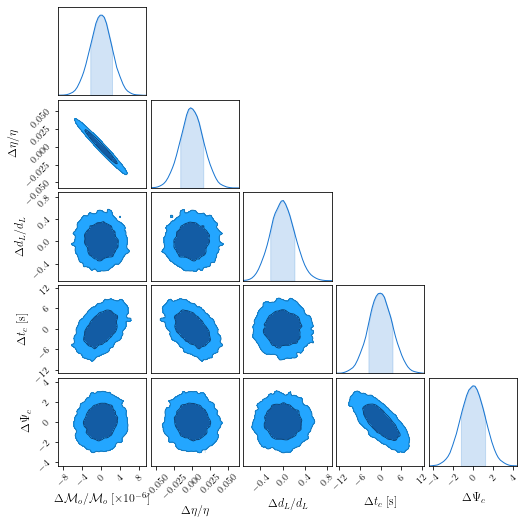

In [16]:
cov_matrix_lisa_GR = np.matmul(rescaling_matrix, np.matmul(cov_lisa_GR, rescaling_matrix))
data_lisa_GR = np.random.multivariate_normal(0 * pars_GR[:-2], cov_matrix_lisa_GR, size=10000)

data_dL_lisa_GR      = np.array(data_lisa_GR)
data_dL_lisa_GR[:,2] = get_dL_Mpc(zem *(1 +data_lisa_GR[:,2])) / get_dL_Mpc(zem) -1
#data_dL_lisa_GR[:,3] *= 1e3

cc = ChainConsumer()
cc.add_chain(data_dL_lisa_GR, bins=30, smooth=True, parameters=label_GR, name='lisa');
cc.plotter.plot();

In [17]:
fisher_tot_GR = fisher_ligo_GR +fisher_lisa_GR
print('Combined conditioning (units 1e15) ', np.linalg.cond(fisher_tot_GR)/1e5)

evals_tot_GR, evecs_tot_GR = np.linalg.eigh(fisher_tot_GR)
print('\nEigenvals:\n', evals_tot_GR)

print('\nSmallest eigenval:\n', evecs_tot_GR[0,:])
print('\nLargest eigenval:\n', evecs_tot_GR[-1,:])

Combined conditioning (units 1e15)  206485538.6163661

Eigenvals:
 [8.12641292e+01 2.19849560e+03 1.40230785e+04 1.75586051e+08
 1.67798675e+15]

Smallest eigenval:
 [ 7.74572378e-06 -2.83583723e-09  1.40539679e-04 -3.28102674e-07
  9.99999990e-01]

Largest eigenval:
 [ 9.98520882e-01  7.42023011e-06 -5.42746139e-02  3.21171377e-03
 -1.05476313e-07]


In [18]:
### Reducing magnitude of some parameters and computing new fisher
rescaling_matrix      = np.eye( len(dlnA_lisa_GR) )
rescaling_matrix[0,0] = 1e-2 #3e-3
rescaling_matrix[1,1] = 1e-2 #1e-7
rescaling_matrix[2,2] = 1e0
rescaling_matrix[3,3] = 1 #1e-1
rescaling_matrix[4,4] = 1 #1e-1

#d_new_ligo = np.matmul(rescaling_matrix, ders_ligo_GR_dist)
new_fisher_tot_GR = np.matmul(rescaling_matrix, np.matmul(fisher_tot_GR, rescaling_matrix))

new_cov_tot_GR = np.linalg.inv(new_fisher_tot_GR)

print('Conditioning / 1e15:', np.linalg.cond(new_fisher_tot_GR)/1e15)

Conditioning / 1e15: 0.00018084123457994312


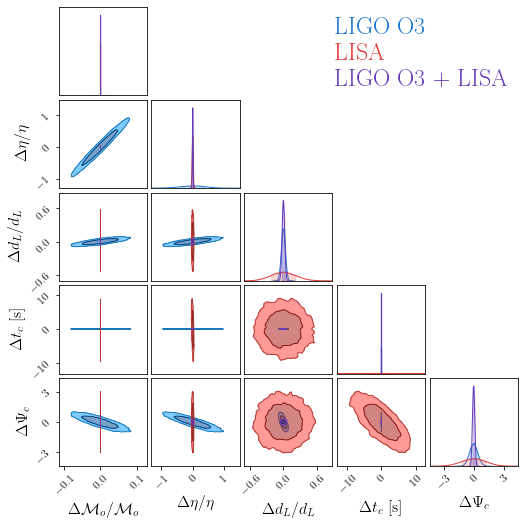

In [22]:
cov_tot_GR  = np.matmul(rescaling_matrix, np.matmul( np.linalg.inv(new_fisher_tot_GR), rescaling_matrix) )
data_tot_GR = np.random.multivariate_normal(0 *pars_GR[:-2], cov_tot_GR, size=10000)

data_dL_tot_GR      = np.array(data_tot_GR)
data_dL_tot_GR[:,2] = get_dL_Mpc(zem *(1 +data_tot_GR[:,2])) / get_dL_Mpc(zem) -1
#data_dL_tot_GR[:,3] *= 1e3

cc = ChainConsumer()
cc.add_chain(data_dL_ligo_GR, bins=30, smooth=True, parameters=label_GR, name='LIGO O3', color='blue');
cc.add_chain(data_dL_lisa_GR, bins=30, smooth=True, parameters=label_GR, name='LISA', color='red');
cc.add_chain(data_dL_tot_GR, bins=30, smooth=True, parameters=label_GR, name='LIGO O3 + LISA', color='purple');
cc.configure(legend_kwargs={"loc": "upper right", "fontsize": 24}, max_ticks=3, label_font_size=16, tick_font_size=12);
cc.plotter.plot();

plt.savefig('Cross_correlation_GR.pdf')

In [23]:
### A table of the constraints for the three cases
print(np.std(data_dL_ligo_GR, axis=0))
print(np.std(data_dL_lisa_GR, axis=0))
print(np.std(data_dL_tot_GR, axis=0))


[0.03251887 0.37394122 0.03525245 0.00107244 0.40110469]
[2.30017300e-06 1.60862001e-02 2.15548146e-01 3.48857997e+00
 1.19262015e+00]
[1.46242215e-06 1.03401877e-02 2.26804874e-02 3.47808293e-04
 1.09962875e-01]


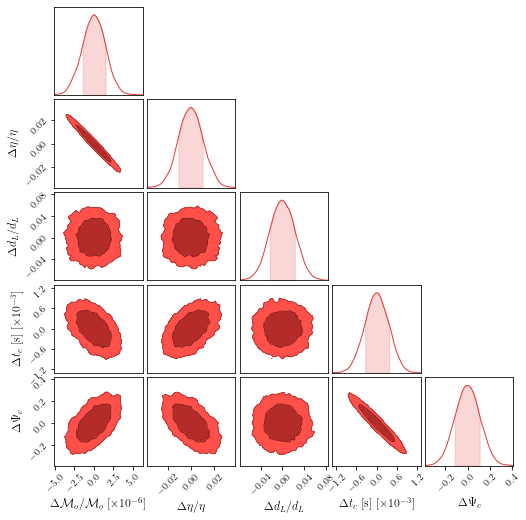

In [24]:
cc = ChainConsumer()
cc.add_chain(data_dL_tot_GR, bins=30, smooth=True, parameters=label_GR, name='cross', color='red');
cc.plotter.plot();

# Step function (no dist corr)

In [25]:
data_dL_tot_GR[:,3] *= 1e3

In [26]:
cT_type = 'step'

# Set parameters for step
fstar = 1
dc0   = 1e-15 #-1e-7
w1    = 1e-3

# Set parameters for runs and evaluate
pars_MG   = np.append(pars_GR[:-2], [dc0, fstar])
fid_vals  = np.append(pars_GR[:-2], [dc0])
nlabel_GR = label_GR.copy()
nlabel_GR[3] = r'$\Delta t_c$ [ms]'
label_MG  = nlabel_GR +[r'$\delta c$']

ppars_MG      = np.array(pars_MG[:-1])

c_vals        = 0 *ppars_MG
c_vals[-1]    = dc0

llabel_MG     = label_MG.copy()
llabel_MG[-1] = r'$\delta c$'

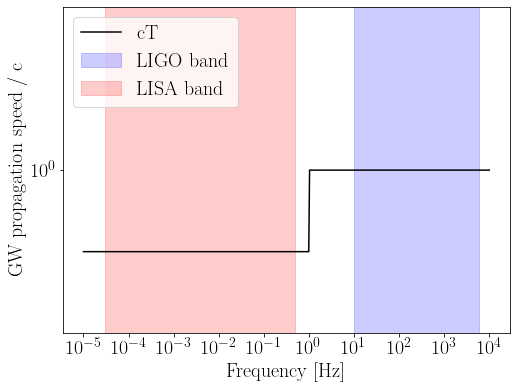

In [47]:
# Evaluate and plot Delta

my_ftot = np.logspace(-5, 4, 500)
cT_fo   = get_cT(my_ftot, f0=fstar, dc0=dc0, cT_type=cT_type)

plt.figure(figsize=(8,6))

plt.loglog(my_ftot, cT_fo, label='cT', color='black')
plt.fill([fligo[0], fligo[-1], fligo[-1], fligo[0]], [1e-2, 1e-2, 1e2, 1e2], color='blue', alpha=.2, label='LIGO band')
plt.fill([flisa[0], flisa[-1], flisa[-1], flisa[0]], [1e-2, 1e-2, 1e2, 1e2], color='red', alpha=.2, label='LISA band')

plt.xticks(np.logspace(-5, 4, 10))
plt.yticks()
plt.ylim(1 - 2* dc0, 1 +2* dc0)
plt.xlabel('Frequency [Hz]')
plt.ylabel('GW propagation speed / c')
plt.legend(loc=2, fontsize=20);
plt.savefig('Ct.pdf')

In [48]:
### LIGO
h_Delta_ligo = h_Delta_inspiral(farr_ligo, pars_MG, cT_type=cT_type, dist_corr=False)

# Derivative for LIGO
dlnA_ligo_MGND, dPsi_ligo_MGND = Fisher_der(farr_ligo, pars_MG, cT_type=cT_type, dist_corr=False)

#dlnA_ligo_MGND   = np.vstack( (dlnA_ligo_MGND, np.zeros(len(farr_ligo)) ))
#dPsi_ligo_MGND   = np.vstack( (dPsi_ligo_MGND, np.zeros(len(farr_ligo)) ))

FlnA_ligo_MGND   = Fisher_build(farr_ligo, ligo_psd, h_Delta_ligo, dlnA_ligo_MGND)
FPsi_ligo_MGND   = Fisher_build(farr_ligo, ligo_psd, h_Delta_ligo, dPsi_ligo_MGND)

fisher_ligo_MGND = FlnA_ligo_MGND +FPsi_ligo_MGND

print('\nLIGO conditioning (units of 1e15)')
print(np.linalg.cond(fisher_ligo_MGND)/1e15)

evals_ligo_MGND, evecs_ligo_MGND = np.linalg.eigh(fisher_ligo_MGND)
print('\nEigenvals:\n', evals_ligo_MGND)

print('\nSmallest eigenval:\n', evecs_ligo_MGND[0,:])
print('\nLargest eigenval:\n', evecs_ligo_MGND[-1,:])

-Working on index 0
Ratio best = 2.79e-14 for dx = 3.34e-01
Ratio best = 5.68e-03 for dx = 1.67e-01
-Working on index 1
Ratio best = 2.42e-03 for dx = 1.40e-01
-Working on index 2
-Working on index 3
-Working on index 4
-Working on index 5
This took 1.64 seconds

LIGO conditioning (units of 1e15)
inf

Eigenvals:
 [0.00000000e+00 3.51574162e+00 5.56301163e+01 2.18067248e+03
 3.95329566e+05 1.75668371e+08]

Smallest eigenval:
 [ 0.          0.05742791 -0.0835441   0.00393641  0.99460407 -0.02167193]

Largest eigenval:
 [ 1.  0.  0.  0.  0. -0.]


In [49]:
### LISA
h_Delta_lisa = h_Delta_inspiral(farr_lisa, pars_MG, cT_type=cT_type, dist_corr=False)

# Derivative for LISA
dlnA_lisa_MGND, dPsi_lisa_MGND = Fisher_der(farr_lisa, pars_MG, cT_type=cT_type, dist_corr=False)

FlnA_lisa_MGND   = Fisher_build(farr_lisa, lisa_psd, h_Delta_lisa, dlnA_lisa_MGND)
FPsi_lisa_MGND   = Fisher_build(farr_lisa, lisa_psd, h_Delta_lisa, dPsi_lisa_MGND)

fisher_lisa_MGND = FlnA_lisa_MGND +FPsi_lisa_MGND

print('\nLISA conditioning (units of 1e15)')
print(np.linalg.cond(fisher_lisa_MGND)/1e15)

evals_lisa_MGND, evecs_lisa_MGND = np.linalg.eigh(fisher_lisa_MGND)
print('\nEigenvals:\n', evals_lisa_MGND)

print('\nSmallest eigenval:\n', evecs_lisa_MGND[0,:])
print('\nLargest eigenval:\n', evecs_lisa_MGND[-1,:])

-Working on index 0
Ratio best = 1.63e-14 for dx = 3.34e-01
Ratio best = 5.68e-03 for dx = 1.67e-01
-Working on index 1
Ratio best = 3.47e-03 for dx = 1.40e-01
-Working on index 2
-Working on index 3
-Working on index 4
-Working on index 5
This took 1.65 seconds

LISA conditioning (units of 1e15)
1964177090939830.5

Eigenvals:
 [3.55271368e-15 7.65213833e-02 1.66728947e+00 4.63784190e+01
 9.95577396e+03 1.67798675e+15]

Smallest eigenval:
 [-4.37726989e-21 -2.66551877e-07 -2.01668283e-06  5.05445685e-11
  1.40738678e-04  9.99999990e-01]

Largest eigenval:
 [ 7.27784738e-01  1.04645296e-07  8.19895981e-07 -6.85805640e-01
  2.58168411e-07  1.08329881e-14]


In [50]:
fisher_tot_MGND = fisher_ligo_MGND +fisher_lisa_MGND

print('\nTOT conditioning (units of 1e15)')
print(np.linalg.cond(fisher_tot_MGND)/1e15)

evals_tot_MGND, evecs_tot_MGND = np.linalg.eigh(fisher_tot_MGND)
print('\nEigenvals:\n', evals_tot_MGND)

print('\nSmallest eigenval:\n', evecs_tot_MGND[0,:])
print('\nLargest eigenval:\n', evecs_tot_MGND[-1,:])


TOT conditioning (units of 1e15)
0.07780349137506598

Eigenvals:
 [2.15669852e+01 8.12641292e+01 2.19874175e+03 1.40230785e+04
 1.75586051e+08 1.67798675e+15]

Smallest eigenval:
 [ 4.35113221e-13  7.74572378e-06 -2.83606013e-09  1.40539679e-04
 -3.28102674e-07  9.99999990e-01]

Largest eigenval:
 [ 9.99943469e-01 -9.05159421e-08  1.06328869e-02  2.16385128e-07
 -3.39673799e-14  1.08329881e-14]


In [51]:
### Reducing magnitude of some parameters and computing new fisher
rescaling_matrix      = np.eye( len(dlnA_ligo_MGND) )
rescaling_matrix[0,0] = 1e0 #e-3
rescaling_matrix[1,1] = 1e0 #1e-7
rescaling_matrix[2,2] = 1e0
rescaling_matrix[3,3] = 1e0
rescaling_matrix[4,4] = 1e0 #1e-1
rescaling_matrix[5,5] = 1e0 #1e-1

new_dlnA_ligo_MGND = np.matmul(rescaling_matrix, dlnA_ligo_MGND)
new_dPsi_ligo_MGND = np.matmul(rescaling_matrix, dPsi_ligo_MGND)
new_dlnA_lisa_MGND = np.matmul(rescaling_matrix, dlnA_lisa_MGND)
new_dPsi_lisa_MGND = np.matmul(rescaling_matrix, dPsi_lisa_MGND)

new_FlnA_ligo_MGND = Fisher_build(farr_ligo, ligo_psd, h_Delta_ligo, new_dlnA_ligo_MGND)
new_FPsi_ligo_MGND = Fisher_build(farr_ligo, ligo_psd, h_Delta_ligo, new_dPsi_ligo_MGND)
new_FlnA_lisa_MGND = Fisher_build(farr_lisa, lisa_psd, h_Delta_lisa, new_dlnA_lisa_MGND)
new_FPsi_lisa_MGND = Fisher_build(farr_lisa, lisa_psd, h_Delta_lisa, new_dPsi_lisa_MGND)

new_fisher_tot_MGND = new_FlnA_ligo_MGND +new_FPsi_ligo_MGND +new_FlnA_lisa_MGND +new_FPsi_lisa_MGND
print('Conditioning / 1e15:', np.linalg.cond(new_fisher_tot_MGND)/1e15)

evals_tot_MGND, evecs_tot_MGND = np.linalg.eigh(new_fisher_tot_MGND)

print('\nEigenvals:\n', evals_tot_MGND)

print('\nSmallest eigenval:\n', evecs_tot_MGND[0,:])
print('\nLargest eigenval:\n', evecs_tot_MGND[-1,:])

new_cov_tot_MGND    = np.linalg.inv(new_fisher_tot_MGND)

Conditioning / 1e15: 0.07780349137506598

Eigenvals:
 [2.15669852e+01 8.12641292e+01 2.19874175e+03 1.40230785e+04
 1.75586051e+08 1.67798675e+15]

Smallest eigenval:
 [ 4.35113221e-13  7.74572378e-06 -2.83606013e-09  1.40539679e-04
 -3.28102674e-07  9.99999990e-01]

Largest eigenval:
 [ 9.99943469e-01 -9.05159421e-08  1.06328869e-02  2.16385128e-07
 -3.39673799e-14  1.08329881e-14]


In [52]:
cov_tot_MGND  = np.matmul(np.matmul(rescaling_matrix, new_cov_tot_MGND), rescaling_matrix)
data_tot_MGND = np.random.multivariate_normal(c_vals, cov_tot_MGND, size=20000)

data_dL_tot_MGND      = np.array(data_tot_MGND)
data_dL_tot_MGND[:,2] = get_dL_Mpc(zem *(1 +data_dL_tot_MGND[:,2])) / get_dL_Mpc(zem) -1
data_dL_tot_MGND[:,3] *= 1e3

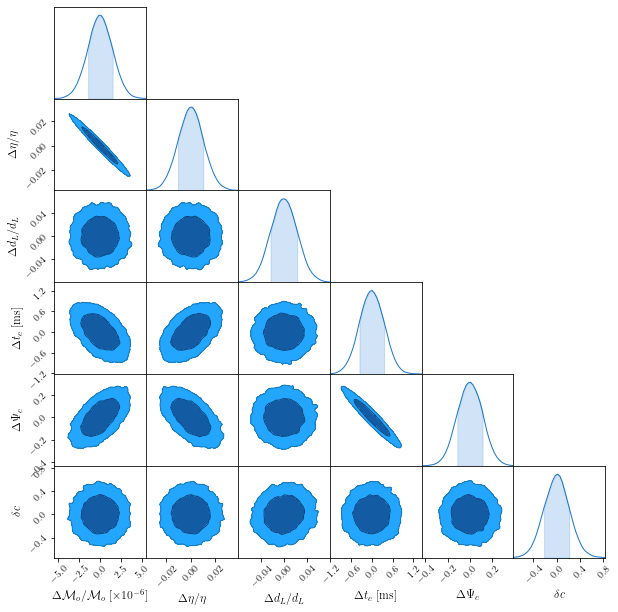

In [53]:
cc = ChainConsumer()
cc.add_chain(data_dL_tot_MGND, bins=30, smooth=True, parameters=llabel_MG, name='cross');
cc.plotter.plot();

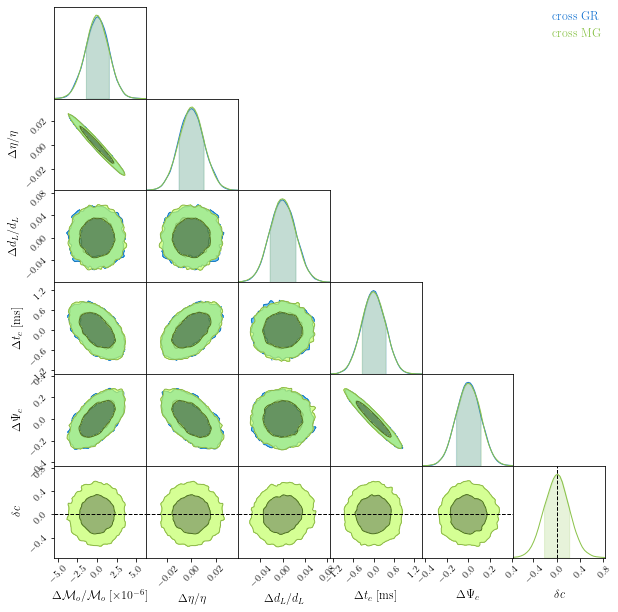

In [54]:
cc = ChainConsumer()

cc.add_chain(data_dL_tot_GR, bins=30, smooth=True, parameters=nlabel_GR, name='cross GR');
cc.add_chain(data_dL_tot_MGND, bins=30, smooth=True, parameters=llabel_MG, name='cross MG');
cc.plotter.plot(truth=[None,None,None,None,None,0.]);

# Step function (dist corr)

In [55]:
### NOW PLUG BACK DIST CORR and recompute derivatives for LIGO!!!
h_Delta_ligo = h_Delta_inspiral(farr_ligo, pars_MG, cT_type=cT_type, dist_corr=True)

# Derivative for LIGO
dlnA_ligo_MGD, dPsi_ligo_MGD = Fisher_der(farr_ligo, pars_MG, cT_type=cT_type, dist_corr=True)

#dlnA_ligo_MGD   = np.vstack( (dlnA_ligo_GRD, np.zeros(len(farr_ligo)) ))
#dPsi_ligo_MGD   = np.vstack( (dPsi_ligo_GRD, np.zeros(len(farr_ligo)) ))

FlnA_ligo_MGD   = Fisher_build(farr_ligo, ligo_psd, h_Delta_ligo, dlnA_ligo_MGD)
FPsi_ligo_MGD   = Fisher_build(farr_ligo, ligo_psd, h_Delta_ligo, dPsi_ligo_MGD)

fisher_ligo_MGD = FlnA_ligo_MGD +FPsi_ligo_MGD

print('\nLIGO conditioning (units of 1e15)')
print(np.linalg.cond(fisher_ligo_MGD)/1e15)

evals_ligo_MGD, evecs_ligo_MGD = np.linalg.eigh(fisher_ligo_MGD)
print('\nEigenvals:\n', evals_ligo_MGD)

print('\nSmallest eigenval:\n', evecs_ligo_MGD[0,:])
print('\nLargest eigenval:\n', evecs_ligo_MGD[-1,:])

-Working on index 0
Ratio best = 2.79e-14 for dx = 3.34e-01
Ratio best = 5.68e-03 for dx = 1.67e-01
-Working on index 1
Ratio best = 2.42e-03 for dx = 1.40e-01
-Working on index 2
-Working on index 3
-Working on index 4
-Working on index 5
This took 1.71 seconds

LIGO conditioning (units of 1e15)
inf

Eigenvals:
 [0.00000000e+00 3.51574162e+00 5.56301163e+01 2.18067248e+03
 3.95329566e+05 1.75668371e+08]

Smallest eigenval:
 [ 0.          0.05742791 -0.0835441   0.00393641  0.99460407 -0.02167193]

Largest eigenval:
 [ 1.  0.  0.  0.  0. -0.]


In [56]:
### NOW PLUG BACK DIST CORR and recompute derivatives for LISA!!!
h_Delta_lisa = h_Delta_inspiral(farr_lisa, pars_MG, cT_type=cT_type, dist_corr=True)

# Derivative for LISA
dlnA_lisa_MGD, dPsi_lisa_MGD = Fisher_der(farr_lisa, pars_MG, cT_type=cT_type, dist_corr=True)

FlnA_lisa_MGD   = Fisher_build(farr_lisa, lisa_psd, h_Delta_lisa, dlnA_lisa_MGD)
FPsi_lisa_MGD   = Fisher_build(farr_lisa, lisa_psd, h_Delta_lisa, dPsi_lisa_MGD)

fisher_lisa_MGD = FlnA_lisa_MGD +FPsi_lisa_MGD

print('\nLISA conditioning (units of 1e15)')
print(np.linalg.cond(fisher_lisa_MGD)/1e15)

evals_lisa_MGD, evecs_lisa_MGD = np.linalg.eigh(fisher_lisa_MGD)
print('\nEigenvals:\n', evals_lisa_MGD)

print('\nSmallest eigenval:\n', evecs_lisa_MGD[0,:])
print('\nLargest eigenval:\n', evecs_lisa_MGD[-1,:])

-Working on index 0
Ratio best = 1.63e-14 for dx = 3.34e-01
Ratio best = 5.68e-03 for dx = 1.67e-01
-Working on index 1
Ratio best = 3.47e-03 for dx = 1.40e-01
-Working on index 2
-Working on index 3
-Working on index 4
-Working on index 5
This took 1.71 seconds

LISA conditioning (units of 1e15)
1.0724571844430476e+34

Eigenvals:
 [-1.15078469e+15 -8.15851770e+06  1.01210152e-07  2.45652862e+01
  4.46795511e+01  1.27874576e+33]

Smallest eigenval:
 [9.99999993e-01 1.15039837e-04 4.58223408e-13 2.02426510e-14
 2.97296929e-07 7.65513271e-10]

Largest eigenval:
 [-7.65513254e-10 -1.94178007e-13  2.57385321e-17  1.08738061e-14
 -5.62050406e-16  1.00000000e+00]


In [57]:
### LIGO GR vs LIGO MG with distance
np.where( np.abs( fisher_ligo_MGD[:-1,:][:,:-1] - fisher_ligo_GR ) > 1e-10 )  

(array([], dtype=int64), array([], dtype=int64))

In [58]:
### Amplitude part of LISA GR vs LISA MG with distance
#np.where( np.abs( FlnA_lisa_MGD[:-1,:][:,:-1] - FlnA_lisa_GRD ) > 1e-10 )  

In [59]:
### Amplitude part of LISA GR vs LISA MG with distance
#np.where( np.abs( FPsi_lisa_MGD[:-1,:][:,:-1] - FPsi_lisa_GRD ) > 1e-10 )  

In [60]:
#(FlnA_lisa_MGD +FPsi_lisa_MGD )[:-1,:][:,:-1] -FlnA_lisa_GRD -FPsi_lisa_GRD

In [61]:
#fisher_lisa_MGD[:-1,:][:,:-1] / fisher_lisa_GRD

In [62]:
FPsi_lisa_MGD[2] / FPsi_lisa_MGD[-1]

array([1.08738062e-14, 1.08738062e-14, 1.08738062e-14, 1.08738062e-14,
       1.08738062e-14, 1.08738062e-14])

In [63]:
 FlnA_lisa_MGD[2] /FPsi_lisa_MGD[2]

array([-1.81225861e-09,  0.00000000e+00,  1.62470474e-04, -0.00000000e+00,
       -0.00000000e+00, -1.66476962e-18])

In [64]:
### Reducing magnitude of some parameters and computing new fisher
rescaling_matrix      = np.eye( len(dlnA_lisa_MGD) )
rescaling_matrix[0,0] = 1e0 #e-3
rescaling_matrix[1,1] = 1e0 #1e-7
rescaling_matrix[2,2] = 1e0
rescaling_matrix[3,3] = 1e0
rescaling_matrix[4,4] = 1e0 #1e-1
rescaling_matrix[5,5] = 1e-11 #1e-1

new_dlnA_ligo_MGD = np.matmul(rescaling_matrix, dlnA_ligo_MGD)
new_dPsi_ligo_MGD = np.matmul(rescaling_matrix, dPsi_ligo_MGD)

new_dlnA_lisa_MGD  = np.matmul(rescaling_matrix, dlnA_lisa_MGD)
new_dPsi_lisa_MGD  = np.matmul(rescaling_matrix, dPsi_lisa_MGD)

new_FlnA_ligo_MGD = Fisher_build(farr_ligo, ligo_psd, h_Delta_ligo, new_dlnA_ligo_MGD)
new_FPsi_ligo_MGD = Fisher_build(farr_ligo, ligo_psd, h_Delta_ligo, new_dPsi_ligo_MGD)

new_FlnA_lisa_MGD  = Fisher_build(farr_lisa, lisa_psd, h_Delta_lisa, new_dlnA_lisa_MGD)
new_FPsi_lisa_MGD  = Fisher_build(farr_lisa, lisa_psd, h_Delta_lisa, new_dPsi_lisa_MGD)

new_fisher_tot_MGD = new_FlnA_ligo_MGD +new_FPsi_ligo_MGD +new_FlnA_lisa_MGD +new_FPsi_lisa_MGD

print('Conditioning / 1e15:', np.linalg.cond(new_fisher_tot_MGD)/1e15)

evals_tot_MGD, evecs_tot_MGD = np.linalg.eigh(new_fisher_tot_MGD)

print('\nEigenvals:\n', evals_tot_MGD)

print('\nSmallest eigenval:\n', evecs_tot_MGD[0,:])
print('\nLargest eigenval:\n', evecs_tot_MGD[-1,:])

new_cov_tot_MGD = np.matmul( np.matmul(evecs_tot_MGD, np.diag(1/evals_tot_MGD)), evecs_tot_MGD.T )

Conditioning / 1e15: 0.024546511881800757

Eigenvals:
 [6.83618049e+01 2.19849300e+03 7.90877383e+03 1.75586051e+08
 7.07657837e+10 1.67804386e+15]

Smallest eigenval:
 [ 1.16235415e-05 -6.00551555e-09  1.41994213e-04  3.45606879e-07
 -5.83386647e-03  9.99982973e-01]

Largest eigenval:
 [-1.80240824e-05  1.08739262e-03 -2.93648231e-04 -3.00910761e-06
  9.99982348e-01  5.83390474e-03]


In [65]:
cov_tot_MGD   = np.matmul(np.matmul(rescaling_matrix, new_cov_tot_MGD), rescaling_matrix)
data_tot_MGD  = np.random.multivariate_normal(c_vals, cov_tot_MGD, size=20000)

data_dL_tot_MGD = np.array(data_tot_MGD)
data_dL_tot_MGD[:,2] = get_dL_Mpc(zem *(1 +data_dL_tot_MGD[:,2])) / get_dL_Mpc(zem) -1
data_dL_tot_MGD[:,3] *= 1e3

2.3768457356833087e-16


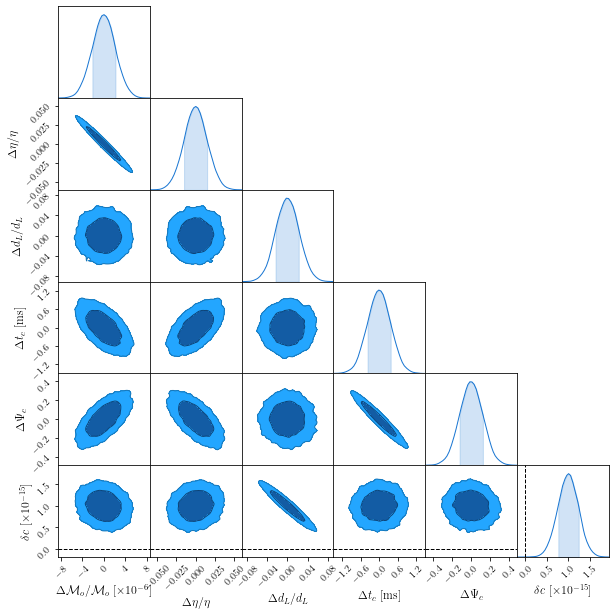

In [66]:
cc = ChainConsumer()
#cc.add_chain(data_tot_MGND, bins=30, smooth=True, parameters=llabel_MG, name='cross MG no dist');
cc.add_chain(data_dL_tot_MGD, bins=30, smooth=True, parameters=llabel_MG, name='cross MG dist');

sigmas = np.std(data_dL_tot_MGD, axis=0)
exts = [(-4 *s, 4 *s) for s in sigmas[:-1]]
exts += [( min(-.2 *dc0, dc0 -4 *sigmas[-1]) , dc0 +4 *sigmas[-1]) ]

cc.plotter.plot(truth=[None,None,None,None,None,0.], extents=exts);

print(sigmas[-1])

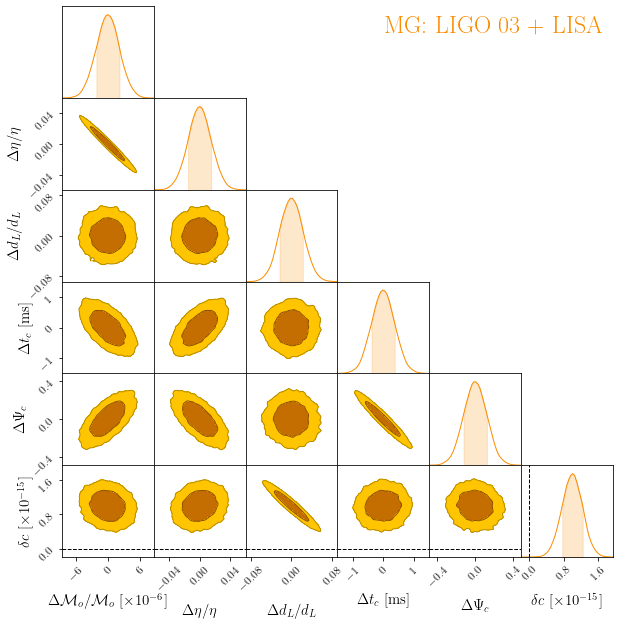

In [68]:
cc = ChainConsumer()

#cc.add_chain(data_dL_tot_GR, bins=30, smooth=True, parameters=nlabel_GR, name='GR: LISA +LIGO O3',  zorder=3, color='blue');
#cc.add_chain(data_dL_tot_MGND, bins=30, smooth=True, parameters=llabel_MG, name='MG: LISA +LIGO O3 no $\Delta t$',  zorder=2);
cc.add_chain(data_dL_tot_MGD, bins=30, smooth=True, parameters=llabel_MG, name='MG: LIGO 03 + LISA', 
        zorder=1, color='orange');
cc.configure(legend_kwargs={"loc": "upper right", "fontsize": 24}, max_ticks=3, label_font_size=15, tick_font_size=12);

fig  = cc.plotter.plot(truth=[None,None,None,None,None,0.], extents=exts, legend=True);
axes = fig.get_axes()
    
#n_pars = len(llabel_MG)
#for i in range(0, n_pars):
#    axes[n_pars *(n_pars-1) +i].set_xlabel(axes[n_pars *(n_pars-1) +i].get_xlabel(), rotation=45, labelpad=+10)
#    axes[n_pars * i].set_ylabel(axes[n_pars * i].get_ylabel(), rotation=90, labelpad=+10)

    
n_pars = len(llabel_MG)
for i in range(0, n_pars):
    axes[n_pars *(n_pars-1) +i].set_xlabel(axes[n_pars *(n_pars-1) +i].get_xlabel(), labelpad=+20)
    axes[n_pars *(n_pars-1) +i].set_xlabel(axes[n_pars *(n_pars-1) +i].get_xlabel(), labelpad=+10)
    
plt.savefig('Final_plot.pdf')

In [ ]:
np.std(my_data_tot_MGD[:,-1])